In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'Variation 7 LSTM Experiments results - FBP'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## First BanCorp.  (Small Cap)

### Test Performance

### non-recession

In [5]:
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
log  = pd.DataFrame(columns = column_names)
logger = []

In [6]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/FBP_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2019-01-22         9.50  9.028269  -2.255619  11013900.0     2.0
2019-01-23         9.40  9.085459 -15.384672   9894000.0     2.0
2019-01-24         9.41  9.135388 -14.615424  11127300.0     2.0
2019-01-25         9.64  9.213021  -0.854639  12071100.0     2.0
2019-01-28         9.74  9.294094  -9.599991  13124000.0     2.0


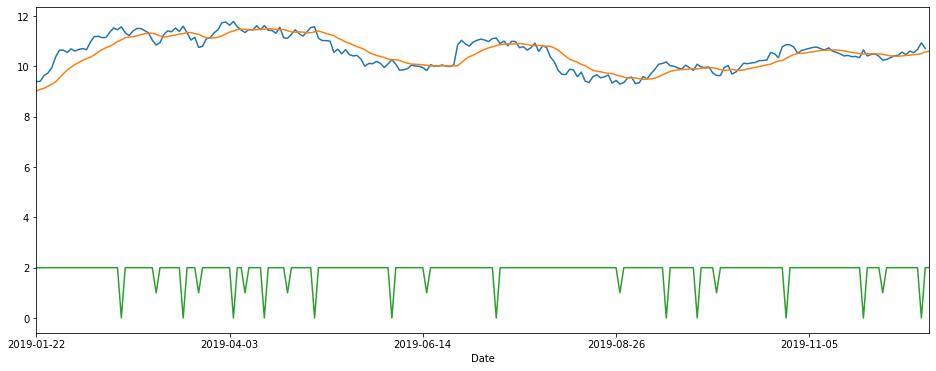

In [7]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [8]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [9]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(218, 15, 4)

In [10]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [11]:
model = tf.keras.models.load_model("models/FBP_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 5ms/step - loss: 0.1968 - accuracy: 0.7477 - mean_squared_error: 8.4180 - weighted_accuracy: 0.7477 - weighted_mean_squared_error: 8.4180
Test loss: 0.1968318223953247
Test accuracy: 0.747706413269043


In [12]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 176, 1: 19, 0: 23})

In [13]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 198, 0: 12, 1: 8})

In [14]:
df = pd.read_csv("data/variation 7/initial_indicators/FBP_data_test.csv")
df.set_index('Date', inplace=True)

In [15]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,10.97,10.368433,-10.526309,20920800.0,2.0,2,2
2019-02-12,11.19,10.460982,-1.226963,21991800.0,2.0,2,2
2019-02-13,11.20,10.573138,-2.673807,23276900.0,2.0,2,2
2019-02-14,11.15,10.669578,-6.432784,24558900.0,2.0,2,2
2019-02-15,11.15,10.743489,-9.815999,23333100.0,2.0,2,2


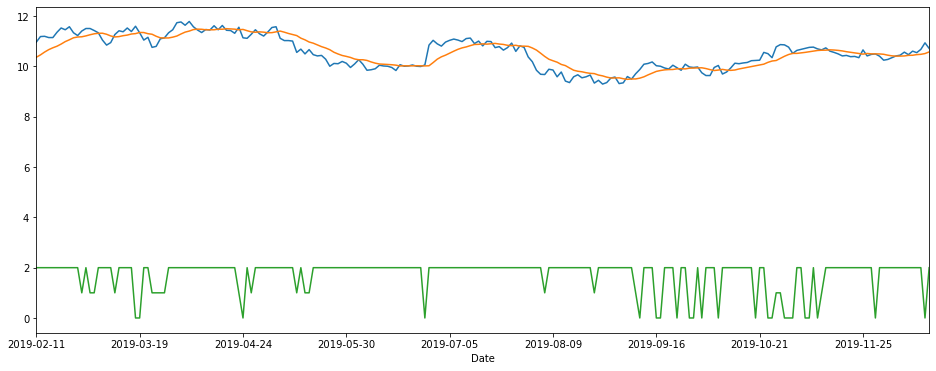

In [16]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

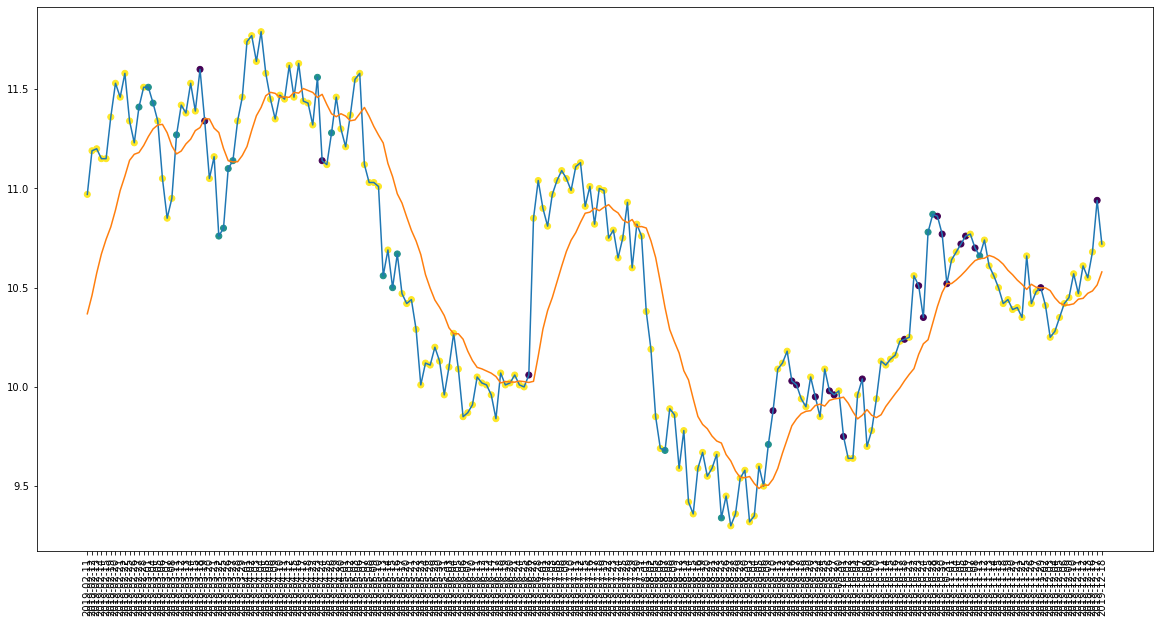

In [17]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

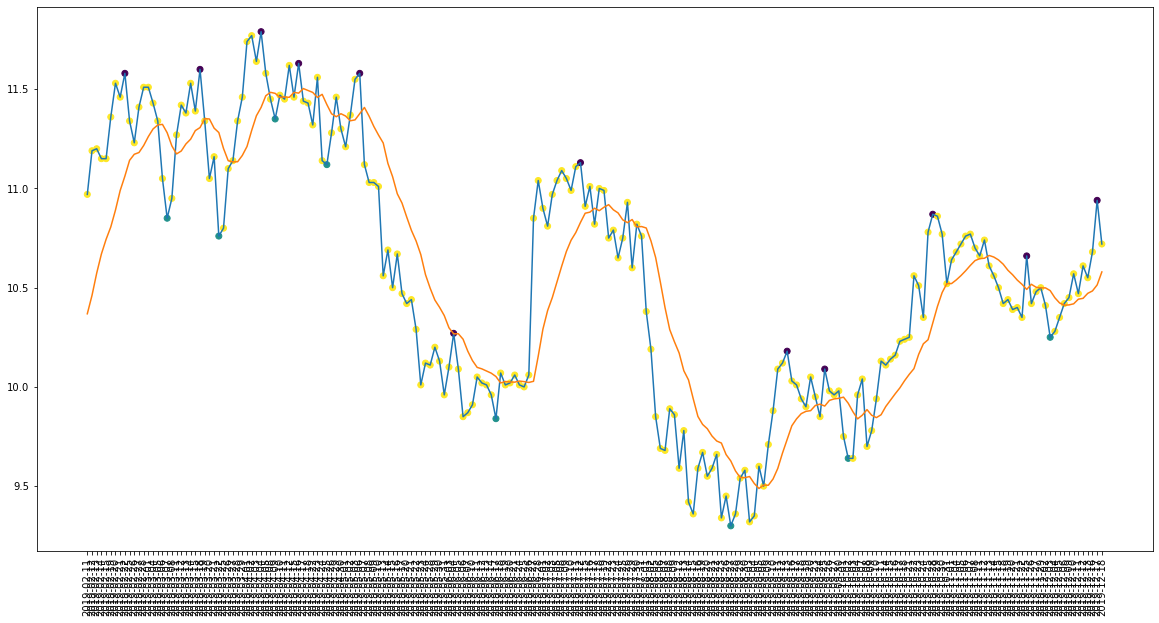

In [18]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [19]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 17
actual holds but predicted sell: 21
actual predicted holds: 160
Percentage buys correct: 12.5%
Percentage sells correct: 16.666666666666668%
Percentage holds correct: 80.8080808080808%
actual buys: 8
actual sells: 12
actual holds: 198


In [20]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[10.970000267028807, 11.149999618530273, 11.149999618530273, 11.1899995803833, 11.199999809265137, 11.359999656677244, 11.460000038146973, 11.529999732971193, 11.579999923706055]
[11.229999542236328, 11.34000015258789, 11.40999984741211, 11.43000030517578, 11.460000038146973, 11.510000228881836, 11.510000228881836, 11.529999732971193, 11.579999923706055]
Percentage buys correct: 63.1578947368421%
Percentage sells correct: 43.47826086956522%
Percentage holds correct: 82.85714285714286%


In [21]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $11.40999984741211
Shares owned at the moment: 874
Cash capital at the moment: $0.23619872856033908


Stop Loss Activated!

Share price: $11.050000190734863
Shares owned at the moment: 0
Cash capital at the moment: $9631.3776899724


Share price: $11.270000457763672
Shares owned at the moment: 852
Cash capital at the moment: $2.931688885209951


Stop Loss Activated!

Share price: $10.760000228881836
Shares owned at the moment: 0
Cash capital at the moment: $9145.241203356263


Share price: $10.760000228881836
Shares owned at the moment: 847
Cash capital at the moment: $6.458278960224561


Stop Loss Activated!

Share price: $10.420000076293944
Shares owned at the moment: 0
Cash capital at the moment: $8807.927558403486


Share price: $9.68000030517578
Shares owned at the moment: 907
Cash capital at the moment: $4.022940847869904


Stop Loss Activated!

Share price: $9.359999656677246
Shares owned at the moment: 0
Cash capital at the moment: $8470.196450310465


Share price:

In [22]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9718.53042116499
profit gained: -2.814695788350109%


In [23]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.747706,12.5%,16.666666666666668%,80.8080808080808%,63.1578947368421%,43.47826086956522%,82.85714285714286%,-14.341034215080835%,-2.814695788350109%


### Recession

In [24]:
logger = []

In [25]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/FBP_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2020-01-22        10.16  10.378210 -80.303008 -2725500.0     2.0
2020-01-23        10.12  10.338485 -84.615464 -4799800.0     2.0
2020-01-24        10.17  10.312565 -73.770502 -3020800.0     2.0
2020-01-27        10.01  10.266016 -83.561649 -4665400.0     2.0
2020-01-28         9.87  10.205091 -87.209337 -6089900.0     2.0


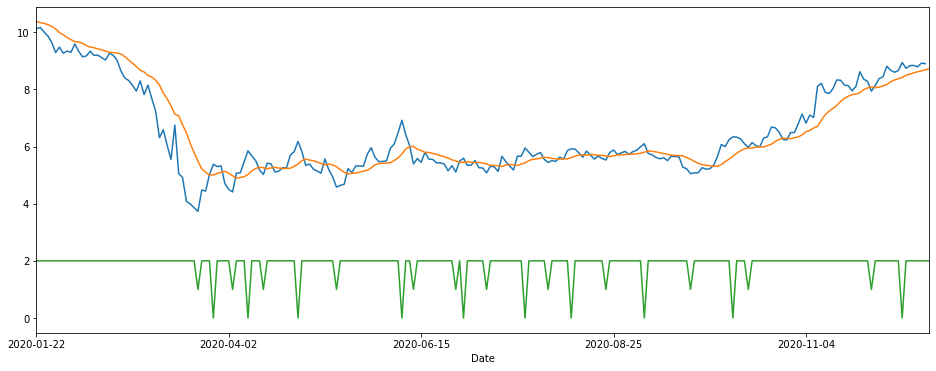

In [26]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [27]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [28]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(219, 15, 4)

In [29]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [30]:
model = tf.keras.models.load_model("models/FBP_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 3ms/step - loss: 0.2018 - accuracy: 0.8128 - mean_squared_error: 10.3997 - weighted_accuracy: 0.8128 - weighted_mean_squared_error: 10.3997
Test loss: 0.2017868459224701
Test accuracy: 0.8127853870391846


In [31]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 194, 1: 8, 0: 17})

In [32]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [33]:
df = pd.read_csv("data/variation 7/initial_indicators/FBP_data_test2.csv")
df.set_index('Date', inplace=True)

In [34]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,9.34,9.482039,-90.677990,-10973800.0,2.0,2,2
2020-02-12,9.19,9.460187,-75.438607,-9769800.0,2.0,2,2
2020-02-13,9.20,9.418620,-88.288360,-11300700.0,2.0,2,2
2020-02-14,9.11,9.384986,-84.782661,-9851300.0,2.0,2,2
2020-02-18,9.03,9.342680,-94.565295,-11123300.0,2.0,2,2


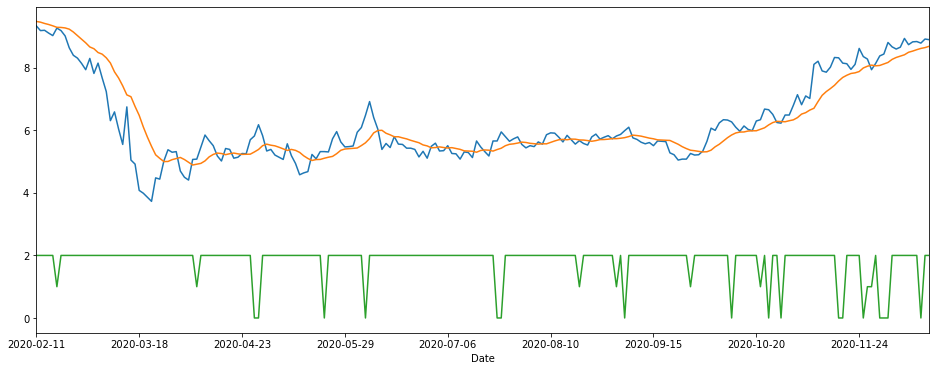

In [35]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

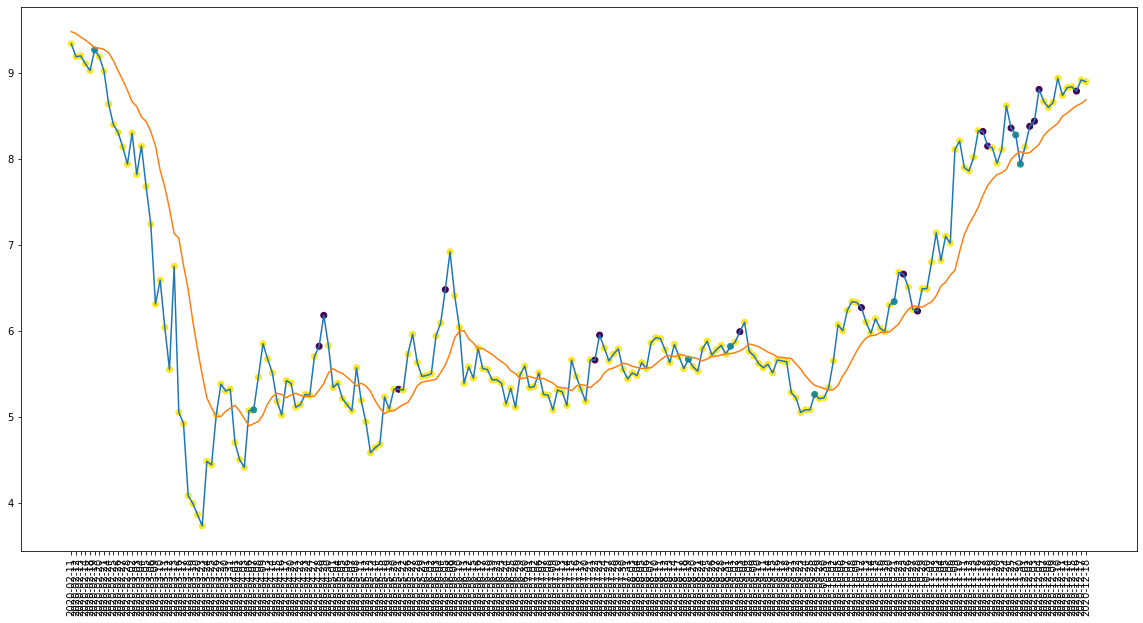

In [36]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

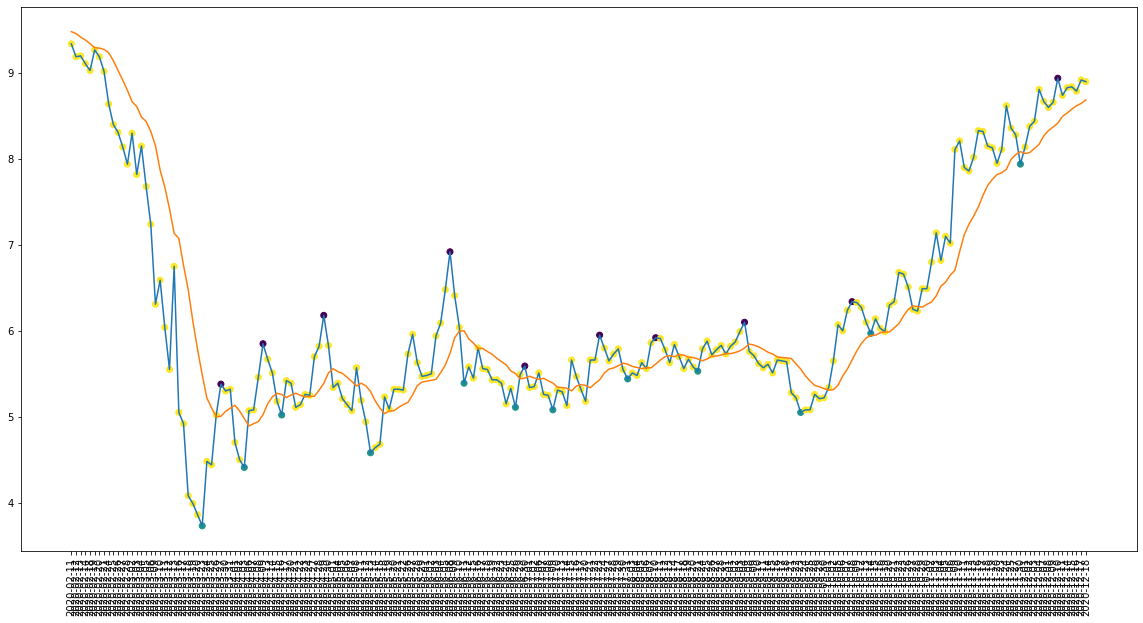

In [37]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [38]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 7
actual holds but predicted sell: 15
actual predicted holds: 175
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 20.0%
Percentage holds correct: 88.83248730964468%
actual buys: 12
actual sells: 10
actual holds: 197


In [39]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[8.640000343322754, 9.020000457763672, 9.029999732971193, 9.109999656677246, 9.1899995803833, 9.1899995803833, 9.199999809265137, 9.270000457763672, 9.34000015258789]
[7.820000171661378, 7.940000057220459, 8.140000343322754, 8.300000190734862, 8.310000419616701, 8.399999618530272, 8.640000343322754, 9.020000457763672, 9.1899995803833]
Percentage buys correct: 12.5%
Percentage sells correct: 76.47058823529412%
Percentage holds correct: 83.93782383419689%


In [40]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $9.270000457763672
Shares owned at the moment: 1075
Cash capital at the moment: $7.345069050788879


Stop Loss Activated!

Share price: $8.640000343322754
Shares owned at the moment: 0
Cash capital at the moment: $9269.803437107801


Share price: $5.079999923706055
Shares owned at the moment: 1819
Cash capital at the moment: $3.8721462681278354


Price increase from previously bought: 14.25273920083967%
Share price: $5.820000171661378
Shares owned at the moment: 0
Cash capital at the moment: $10561.339362661482


Share price: $5.670000076293945
Shares owned at the moment: 1857
Cash capital at the moment: $3.1939480940109206


Price increase from previously bought: 5.354009991366637%
Share price: $5.989999771118164
Shares owned at the moment: 0
Cash capital at the moment: $11096.034091729283


Share price: $5.260000228881836
Shares owned at the moment: 2103
Cash capital at the moment: $3.8337140671010275


Price increase from previously bought: 18.874610185031027%
Share pri

In [41]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9476.998710832118
profit gained: -5.2300128916788164%


In [42]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.747706,12.5%,16.666666666666668%,80.8080808080808%,63.1578947368421%,43.47826086956522%,82.85714285714286%,-14.341034215080835%,-2.814695788350109%
1,0.812785,8.333333333333334%,20.0%,88.83248730964468%,12.5%,76.47058823529412%,83.93782383419689%,71.82039303868886%,-5.2300128916788164%


## American Financial Group, Inc. (Mid Cap)

### Test Performance

#### Non-Recession

In [43]:
logger = []

In [44]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/AFG_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2019-01-22    95.959999  92.750365  -1.891883  2019300.0     2.0
2019-01-23    95.279999  93.139539 -17.336730  1754000.0     2.0
2019-01-24    95.690002  93.531918 -12.247481  2036400.0     2.0
2019-01-25    95.019997  93.760853 -21.494180  1640100.0     2.0
2019-01-28    94.750000  93.913030 -25.032797  1462200.0     2.0


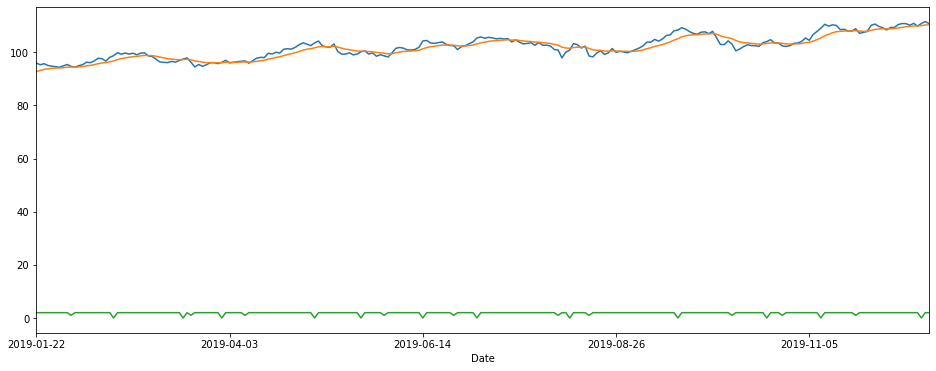

In [45]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

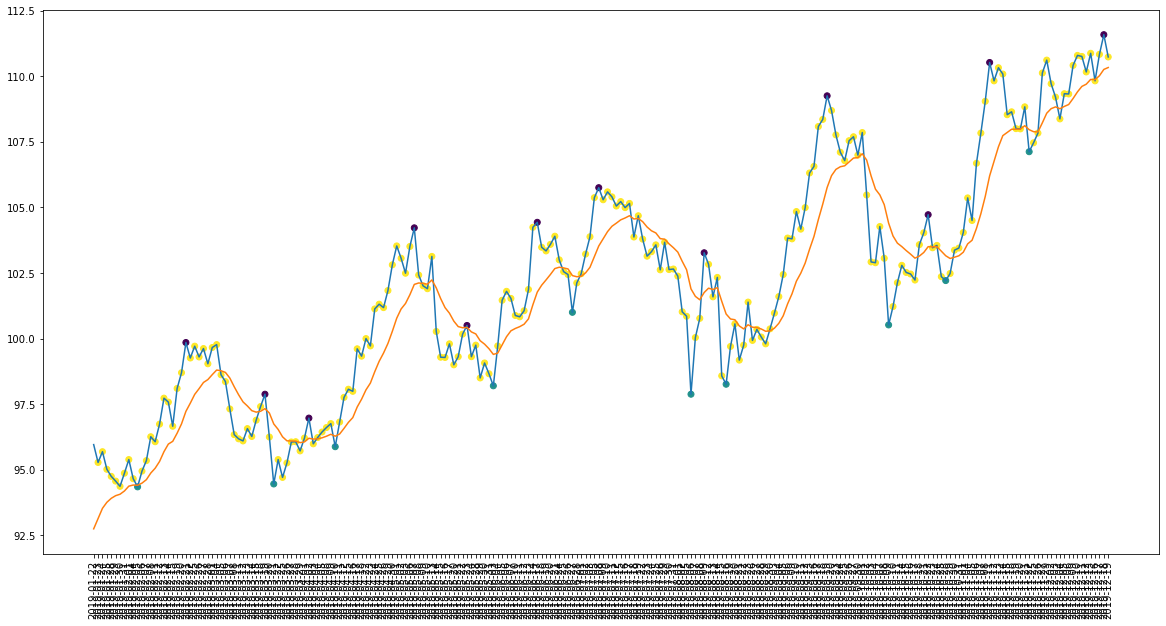

In [46]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['labels'].shift(1).values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [47]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [48]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(218, 15, 4)

In [49]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [50]:
model = tf.keras.models.load_model("models/FBP_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 3ms/step - loss: 0.2299 - accuracy: 0.7569 - mean_squared_error: 9.1986 - weighted_accuracy: 0.7569 - weighted_mean_squared_error: 9.1986
Test loss: 0.22987714409828186
Test accuracy: 0.7568807601928711


In [51]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 181, 0: 29, 1: 8})

In [52]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 197, 0: 12, 1: 9})

In [53]:
df = pd.read_csv("data/variation 7/initial_indicators/AFG_data_test.csv")
df.set_index('Date', inplace=True)

In [54]:
# df['previous_1d'] = df['previous_1d'].shift(-1)
# df.dropna(inplace=True)
# df = df.iloc[13:]
# df['predictions'] = predictions
# df['actual'] = actual
# df.head()

In [55]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,96.739998,95.059703,-9.133179,1855500.0,2.0,2,2
2019-02-12,97.730003,95.318210,-3.111098,2267700.0,2.0,2,2
2019-02-13,97.580002,95.689255,-5.992454,2702600.0,2.0,2,2
2019-02-14,96.660004,95.980139,-17.449632,2348300.0,2.0,2,2
2019-02-15,98.099998,96.084734,-27.740437,1928300.0,2.0,2,2


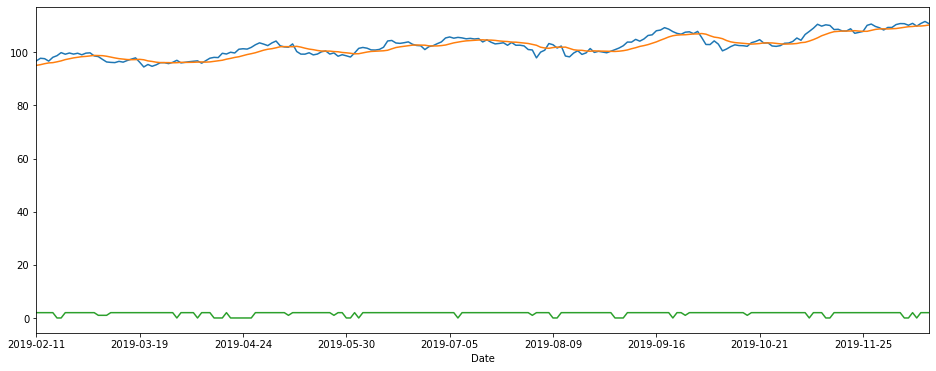

In [56]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

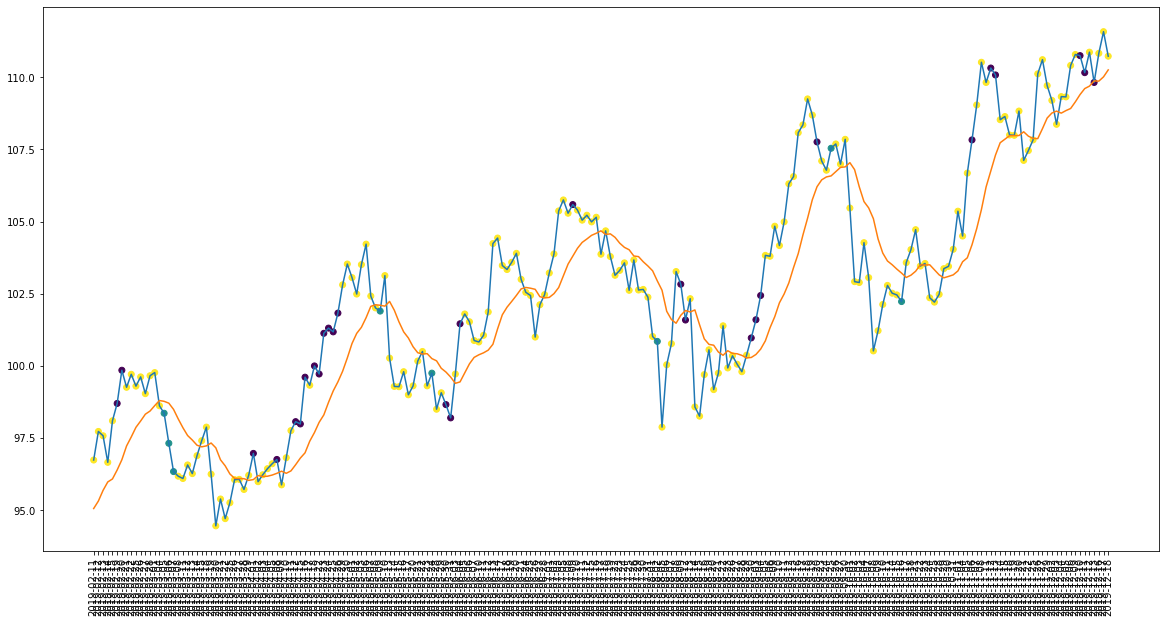

In [57]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

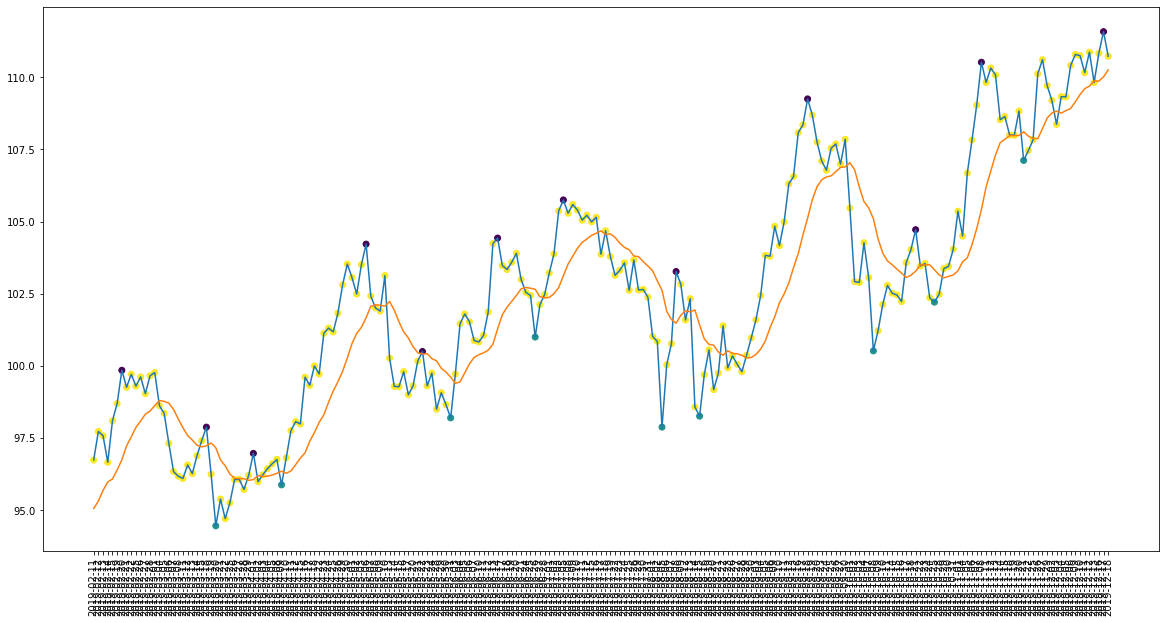

In [58]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [59]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 1
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 10
actual holds but predicted buy: 8
actual holds but predicted sell: 26
actual predicted holds: 163
Percentage buys correct: 0.0%
Percentage sells correct: 16.666666666666668%
Percentage holds correct: 82.74111675126903%
actual buys: 9
actual sells: 12
actual holds: 197


In [60]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[96.66000366210938, 96.73999786376952, 97.58000183105469, 97.7300033569336, 98.0999984741211, 98.6999969482422, 99.26000213623048, 99.70999908447266, 99.8499984741211]
[98.62000274658205, 99.04000091552734, 99.26000213623048, 99.3000030517578, 99.62000274658205, 99.66000366210938, 99.70999908447266, 99.7699966430664, 99.8499984741211]
Percentage buys correct: 50.0%
Percentage sells correct: 48.275862068965516%
Percentage holds correct: 82.77777777777777%


In [61]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $98.36000061035156
Shares owned at the moment: 101
Cash capital at the moment: $38.32044818496615


Stop Loss Activated!

Share price: $94.45999908447266
Shares owned at the moment: 0
Cash capital at the moment: $9552.544090970992


Share price: $101.9000015258789
Shares owned at the moment: 93
Cash capital at the moment: $49.78302367401011


Stop Loss Activated!

Share price: $99.0
Shares owned at the moment: 0
Cash capital at the moment: $9231.46377367401


Share price: $99.75
Shares owned at the moment: 92
Cash capital at the moment: $29.227023674009615


Price increase from previously bought: 5.5643310099138255%
Share price: $105.58999633789062
Shares owned at the moment: 0
Cash capital at the moment: $9716.79241768646


Share price: $100.8499984741211
Shares owned at the moment: 96
Cash capital at the moment: $8.568164573665854


Stop Loss Activated!

Share price: $97.87999725341795
Shares owned at the moment: 0
Cash capital at the moment: $9379.207581626886


Share p

In [62]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $11382.204687950136
profit gained: 13.82204687950136%


In [63]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.747706,12.5%,16.666666666666668%,80.8080808080808%,63.1578947368421%,43.47826086956522%,82.85714285714286%,-14.341034215080835%,-2.814695788350109%
1,0.812785,8.333333333333334%,20.0%,88.83248730964468%,12.5%,76.47058823529412%,83.93782383419689%,71.82039303868886%,-5.2300128916788164%
2,0.756881,0.0%,16.666666666666668%,82.74111675126903%,50.0%,48.275862068965516%,82.77777777777777%,-6.309434333553381%,13.82204687950136%


#### Recession

In [64]:
logger = []

In [65]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/AFG_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14     OBV_7  labels
Date                                                            
2020-01-22   110.709999  110.318220 -37.234155  495600.0     2.0
2020-01-23   110.660004  110.370802 -39.007042   43700.0     2.0
2020-01-24   110.239998  110.350678 -53.900867 -231100.0     2.0
2020-01-27   110.489998  110.372112 -45.035617   27900.0     1.0
2020-01-28   108.529999  110.088710 -98.475749 -331600.0     2.0


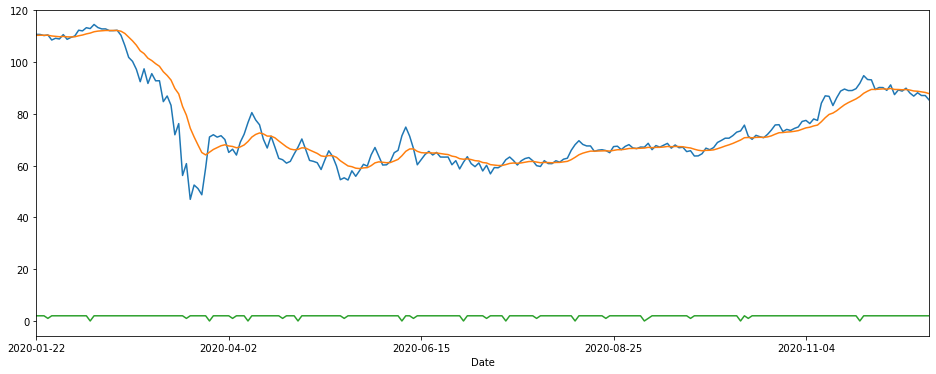

In [66]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

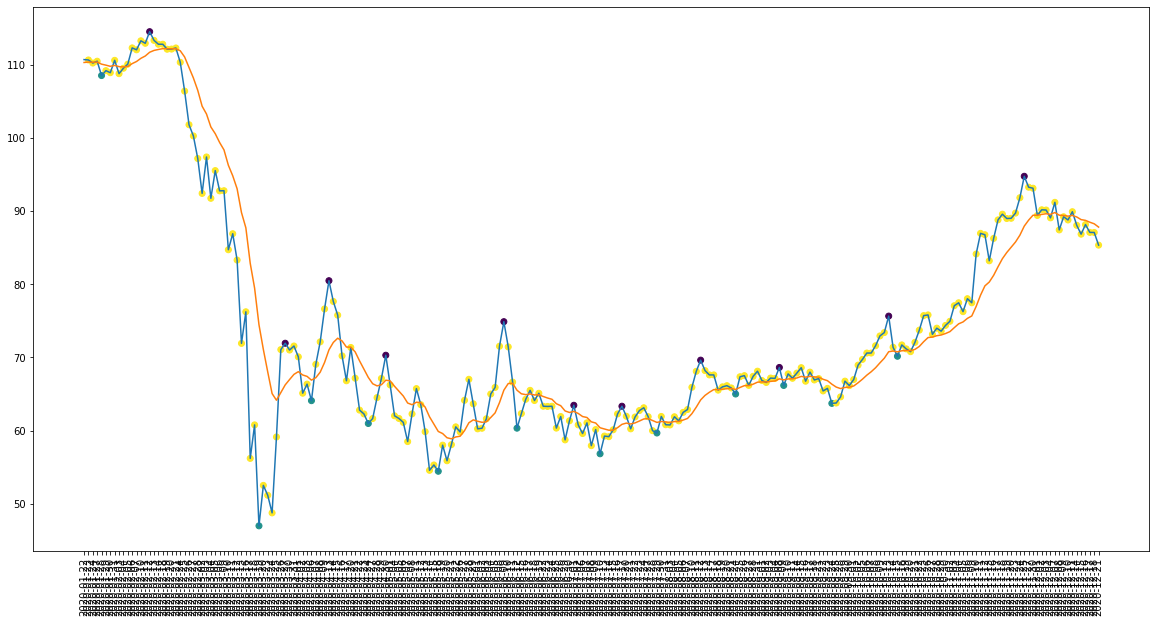

In [67]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['labels'].shift(1).values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [68]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [69]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(219, 15, 4)

In [70]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [71]:
model = tf.keras.models.load_model("models/FBP_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 3ms/step - loss: 0.2051 - accuracy: 0.7626 - mean_squared_error: 8.6598 - weighted_accuracy: 0.7626 - weighted_mean_squared_error: 8.6598
Test loss: 0.2051400989294052
Test accuracy: 0.7625570893287659


In [72]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 183, 1: 18, 0: 18})

In [73]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({0: 11, 2: 197, 1: 11})

In [74]:
df = pd.read_csv("data/variation 7/initial_indicators/AFG_data_test2.csv")
df.set_index('Date', inplace=True)

In [75]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,114.529999,111.202616,-8.193579,1034000.0,0.0,2,0
2020-02-12,113.339996,111.714521,-7.122511,1370400.0,2.0,2,2
2020-02-13,112.809998,111.964594,-24.074120,1072300.0,2.0,2,2
2020-02-14,112.809998,112.094656,-31.623964,742100.0,2.0,2,2
2020-02-18,112.129997,112.204709,-31.623964,742100.0,2.0,2,2


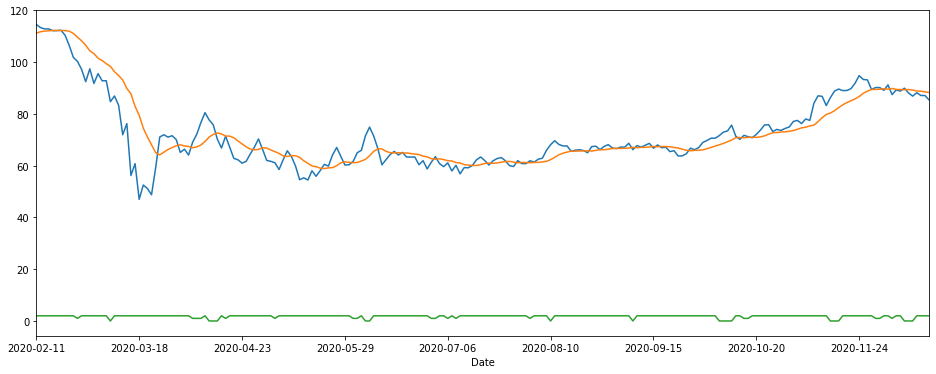

In [76]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

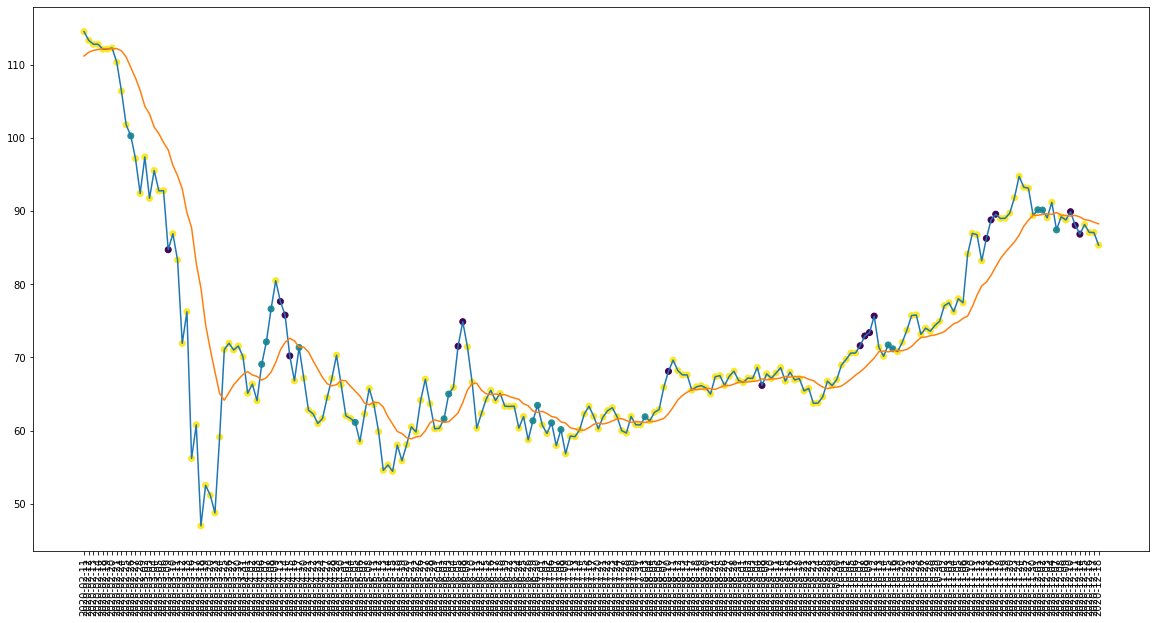

In [77]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

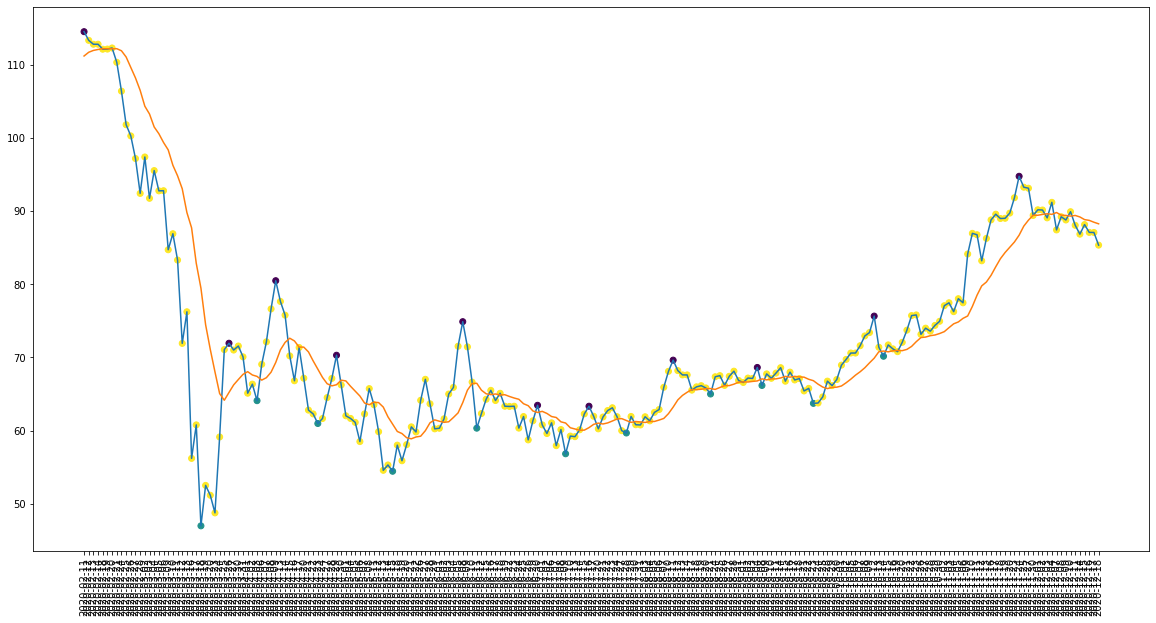

In [78]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [79]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 1
actual buys but predicted hold: 10
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 17
actual holds but predicted sell: 15
actual predicted holds: 165
Percentage buys correct: 0.0%
Percentage sells correct: 18.181818181818183%
Percentage holds correct: 83.75634517766497%
actual buys: 11
actual sells: 11
actual holds: 197


In [80]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[106.4000015258789, 110.33999633789062, 112.12999725341795, 112.1500015258789, 112.3000030517578, 112.80999755859376, 112.80999755859376, 113.33999633789062, 114.52999877929688]
[91.75, 92.41999816894531, 97.19000244140624, 97.4000015258789, 100.27999877929688, 101.80999755859376, 106.4000015258789, 110.33999633789062, 112.3000030517578]
Percentage buys correct: 27.77777777777778%
Percentage sells correct: 61.111111111111114%
Percentage holds correct: 82.96703296703296%


In [81]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $100.27999877929688
Shares owned at the moment: 99
Cash capital at the moment: $44.97889118194507


Stop Loss Activated!

Share price: $97.19000244140624
Shares owned at the moment: 0
Cash capital at the moment: $9640.329154716488


Share price: $69.05999755859375
Shares owned at the moment: 139
Cash capital at the moment: $14.591310005183914


Price increase from previously bought: 12.130107698989413%
Share price: $77.6500015258789
Shares owned at the moment: 0
Cash capital at the moment: $10778.259809019084


Share price: $71.36000061035156
Shares owned at the moment: 150
Cash capital at the moment: $44.82371721458003


Stop Loss Activated!

Share price: $67.16000366210939
Shares owned at the moment: 0
Cash capital at the moment: $10091.120765020367


Share price: $61.11999893188477
Shares owned at the moment: 164
Cash capital at the moment: $39.87582067298354


Stop Loss Activated!

Share price: $58.5
Shares owned at the moment: 0
Cash capital at the moment: $9607.49232

In [82]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7413.518684106826
profit gained: -25.86481315893174%


In [83]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.747706,12.5%,16.666666666666668%,80.8080808080808%,63.1578947368421%,43.47826086956522%,82.85714285714286%,-14.341034215080835%,-2.814695788350109%
1,0.812785,8.333333333333334%,20.0%,88.83248730964468%,12.5%,76.47058823529412%,83.93782383419689%,71.82039303868886%,-5.2300128916788164%
2,0.756881,0.0%,16.666666666666668%,82.74111675126903%,50.0%,48.275862068965516%,82.77777777777777%,-6.309434333553381%,13.82204687950136%
3,0.762557,0.0%,18.181818181818183%,83.75634517766497%,27.77777777777778%,61.111111111111114%,82.96703296703296%,16.43869816833485%,-25.86481315893174%


## JPMorgan Chase & Co. (Large Cap)

### Test Performance

#### Non-Recession

In [84]:
logger = []

In [85]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/JPM_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   104.589996  101.198442  -3.459880  84335200.0     2.0
2019-01-23   102.940002  101.466374 -21.874992  67251500.0     2.0
2019-01-24   102.680000  101.653086 -27.040213  55104800.0     2.0
2019-01-25   102.739998  101.820303 -32.628441  66401600.0     2.0
2019-01-28   103.389999  102.061795 -23.968276  80771000.0     2.0


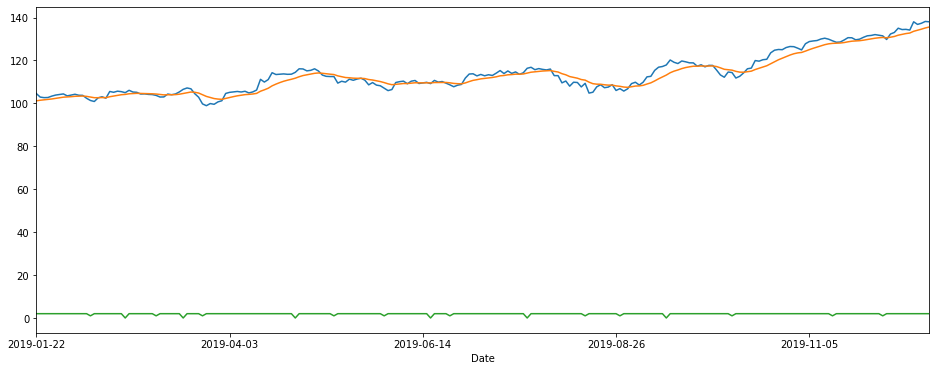

In [86]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [88]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [89]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(218, 15, 4)

In [90]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [91]:
model = tf.keras.models.load_model("models/FBP_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 3ms/step - loss: 0.1954 - accuracy: 0.7385 - mean_squared_error: 7.9666 - weighted_accuracy: 0.7385 - weighted_mean_squared_error: 7.9666
Test loss: 0.19535309076309204
Test accuracy: 0.7385321259498596


In [92]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 174, 1: 16, 0: 28})

In [93]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [94]:
df = pd.read_csv("data/variation 7/initial_indicators/JPM_data_test.csv")
df.set_index('Date', inplace=True)

In [95]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,100.879997,102.975915,-74.903417,73097300.0,1.0,2,1
2019-02-12,102.599998,102.653466,-84.169891,62118800.0,2.0,2,2
2019-02-13,103.089996,102.645240,-50.965236,74971100.0,2.0,2,2
2019-02-14,102.419998,102.713664,-41.505819,85725200.0,2.0,2,2
2019-02-15,105.550003,102.668485,-54.440145,74206700.0,2.0,2,2


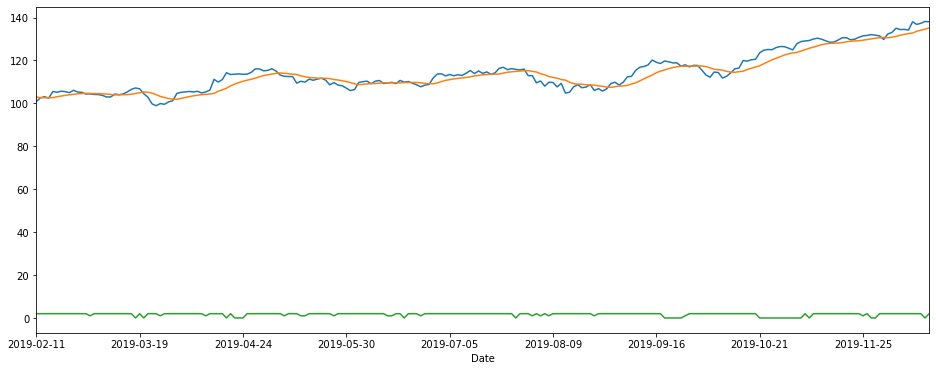

In [96]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

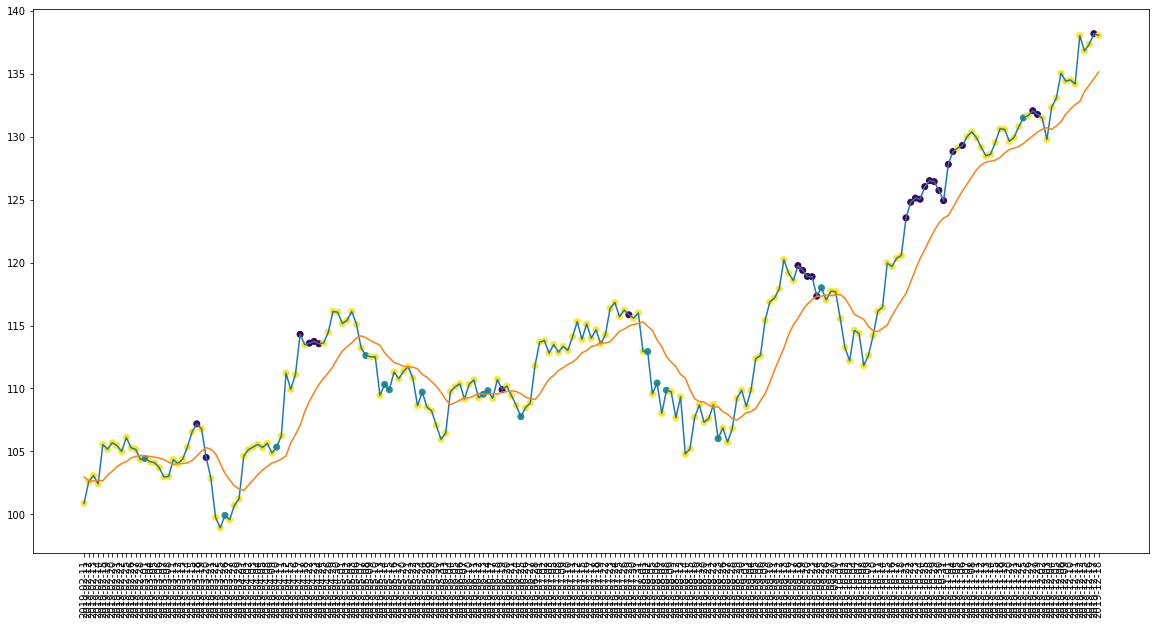

In [97]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

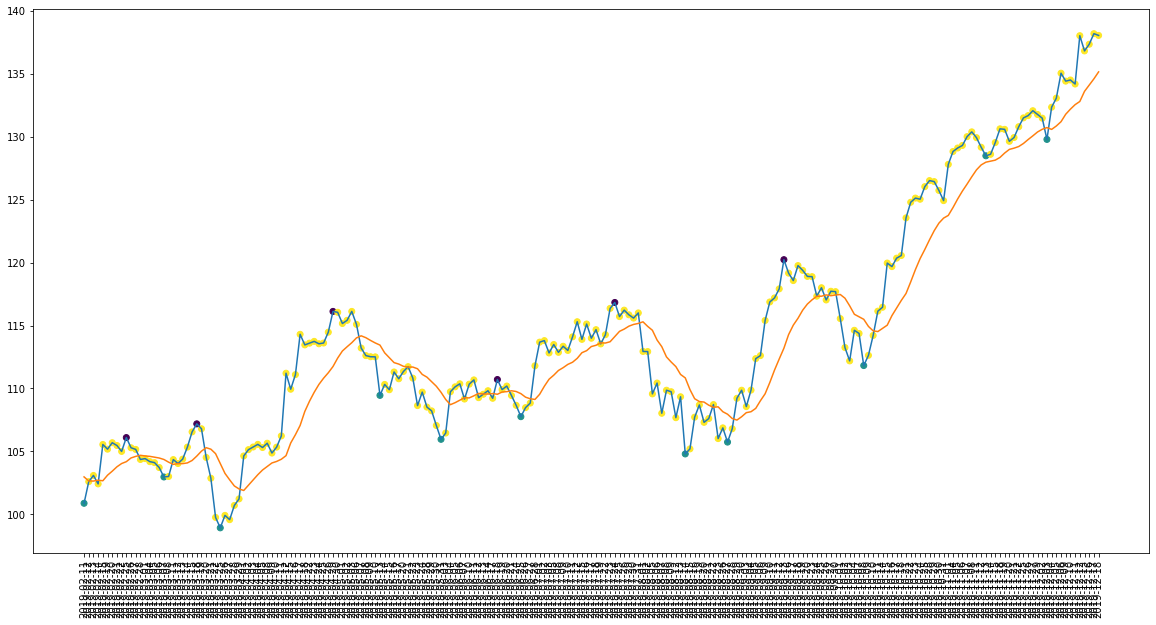

In [98]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [99]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 5
actual holds but predicted buy: 15
actual holds but predicted sell: 27
actual predicted holds: 159
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 16.666666666666668%
Percentage holds correct: 79.1044776119403%
actual buys: 11
actual sells: 6
actual holds: 201


In [100]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[100.87999725341795, 102.41999816894531, 102.5999984741211, 103.08999633789062, 105.0, 105.18000030517578, 105.47000122070312, 105.5500030517578, 105.69000244140624]
[104.19000244140624, 104.36000061035156, 104.43000030517578, 105.0, 105.16000366210938, 105.29000091552734, 105.47000122070312, 105.69000244140624, 106.0999984741211]
Percentage buys correct: 50.0%
Percentage sells correct: 57.142857142857146%
Percentage holds correct: 84.97109826589596%


In [101]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $104.43000030517578
Shares owned at the moment: 95
Cash capital at the moment: $51.867633428573754


Stop Loss Activated!

Share price: $99.76000213623048
Shares owned at the moment: 0
Cash capital at the moment: $9503.00553581238


Share price: $99.91999816894531
Shares owned at the moment: 94
Cash capital at the moment: $84.69638840484731


Price increase from previously bought: 14.077804398920835%
Share price: $114.3000030517578
Shares owned at the moment: 0
Cash capital at the moment: $10799.3501244812


Share price: $112.61000061035156
Shares owned at the moment: 95
Cash capital at the moment: $71.98070383834602


Stop Loss Activated!

Share price: $109.4499969482422
Shares owned at the moment: 0
Cash capital at the moment: $10441.136602218627


Share price: $110.31999969482422
Shares owned at the moment: 94
Cash capital at the moment: $42.53891098403801


Stop Loss Activated!

Share price: $107.05999755859376
Shares owned at the moment: 0
Cash capital at the moment: 

In [102]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $13577.290673755644
profit gained: 35.77290673755644%


In [103]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.747706,12.5%,16.666666666666668%,80.8080808080808%,63.1578947368421%,43.47826086956522%,82.85714285714286%,-14.341034215080835%,-2.814695788350109%
1,0.812785,8.333333333333334%,20.0%,88.83248730964468%,12.5%,76.47058823529412%,83.93782383419689%,71.82039303868886%,-5.2300128916788164%
2,0.756881,0.0%,16.666666666666668%,82.74111675126903%,50.0%,48.275862068965516%,82.77777777777777%,-6.309434333553381%,13.82204687950136%
3,0.762557,0.0%,18.181818181818183%,83.75634517766497%,27.77777777777778%,61.111111111111114%,82.96703296703296%,16.43869816833485%,-25.86481315893174%
4,0.738532,9.090909090909092%,16.666666666666668%,79.1044776119403%,50.0%,57.142857142857146%,84.97109826589596%,7.981967279815618%,35.77290673755644%


### Recession

In [104]:
logger = []

In [105]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/JPM_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   136.839996  137.690058 -77.454723  33776700.0     2.0
2020-01-23   136.679993  137.534664 -80.363881  26227600.0     2.0
2020-01-24   136.539993  137.381637 -69.867648  16881900.0     2.0
2020-01-27   133.149994  136.730615 -90.166021   1715500.0     1.0
2020-01-28   132.029999  136.007444 -79.004573 -11145000.0     2.0


In [106]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [107]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(219, 15, 4)

In [108]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [109]:
model = tf.keras.models.load_model("models/FBP_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 3ms/step - loss: 0.2245 - accuracy: 0.8128 - mean_squared_error: 8.6086 - weighted_accuracy: 0.8128 - weighted_mean_squared_error: 8.6086
Test loss: 0.22446224093437195
Test accuracy: 0.8127853870391846


In [110]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 196, 0: 17, 1: 6})

In [111]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [112]:
df = pd.read_csv("data/variation 7/initial_indicators/JPM_data_test2.csv")
df.set_index('Date', inplace=True)

In [113]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,138.000000,136.179383,-6.410124,26757600.0,0.0,2,0
2020-02-12,138.000000,136.459478,-9.001177,33336200.0,2.0,2,2
2020-02-13,137.880005,136.696481,-13.465502,33336200.0,2.0,0,2
2020-02-14,137.460007,136.878562,-14.718062,25888700.0,2.0,0,2
2020-02-18,135.639999,136.968015,-23.401387,19261100.0,2.0,2,2


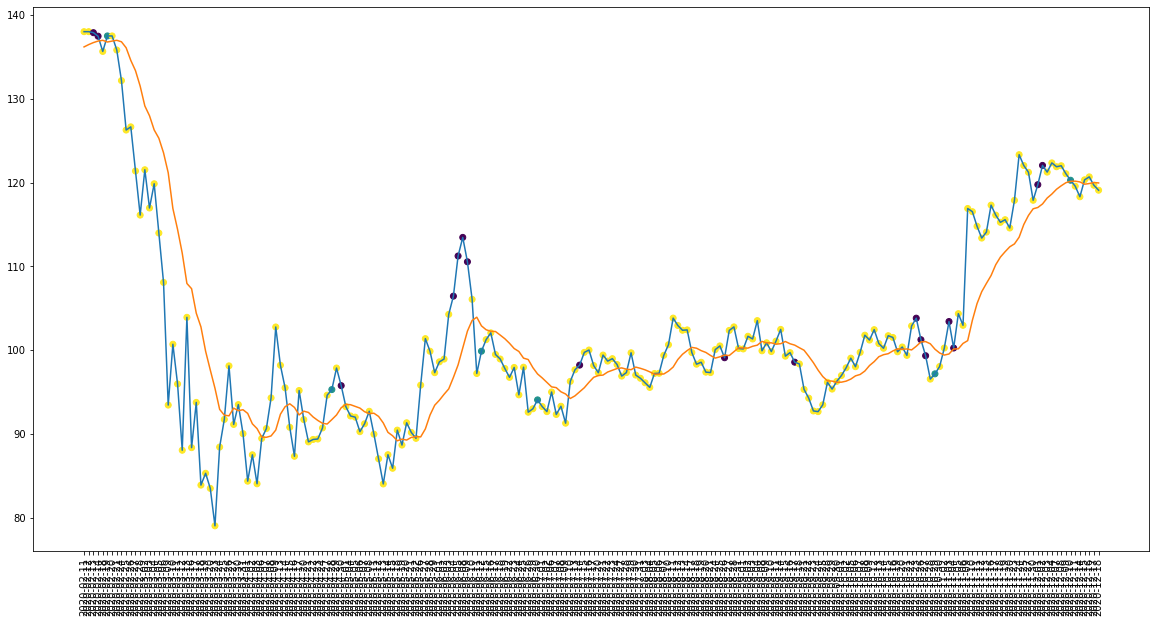

In [114]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

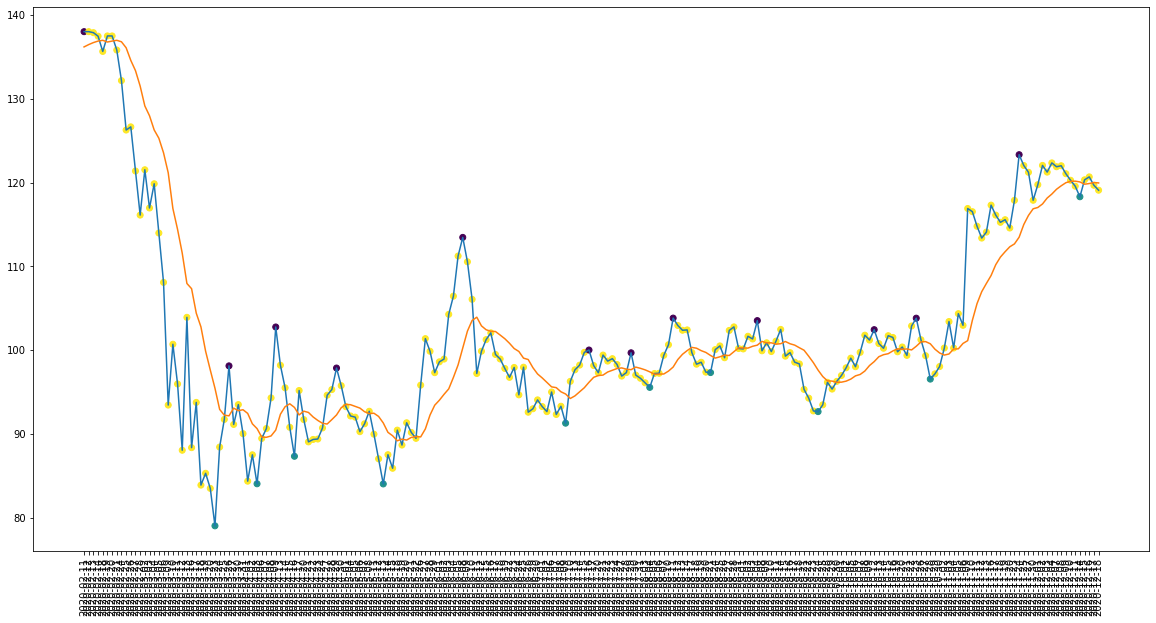

In [115]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [116]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 10
actual holds but predicted buy: 6
actual holds but predicted sell: 15
actual predicted holds: 176
Percentage buys correct: 0.0%
Percentage sells correct: 16.666666666666668%
Percentage holds correct: 89.34010152284264%
actual buys: 10
actual sells: 12
actual holds: 197


In [117]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[132.16000366210938, 135.63999938964844, 135.80999755859378, 137.46000671386722, 137.49000549316406, 137.49000549316406, 137.8800048828125, 138.0, 138.0]
[116.11000061035156, 116.95999908447266, 121.37000274658205, 121.5199966430664, 126.26000213623048, 126.63999938964844, 132.16000366210938, 135.80999755859378, 137.49000549316406]
Percentage buys correct: 50.0%
Percentage sells correct: 70.58823529411765%
Percentage holds correct: 82.05128205128206%


In [118]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $137.49000549316406
Shares owned at the moment: 72
Cash capital at the moment: $73.49658340454152


Stop Loss Activated!

Share price: $132.16000366210938
Shares owned at the moment: 0
Cash capital at the moment: $9562.849166351318


Share price: $95.29000091552734
Shares owned at the moment: 100
Cash capital at the moment: $7.644324546812641


Stop Loss Activated!

Share price: $92.13999938964844
Shares owned at the moment: 0
Cash capital at the moment: $9196.305763679502


Share price: $99.87000274658205
Shares owned at the moment: 91
Cash capital at the moment: $83.14304555320268


Stop Loss Activated!

Share price: $96.75
Shares owned at the moment: 0
Cash capital at the moment: $8863.181358053202


Share price: $94.05999755859376
Shares owned at the moment: 93
Cash capital at the moment: $91.54574072837022


Stop Loss Activated!

Share price: $91.27999877929688
Shares owned at the moment: 0
Cash capital at the moment: $8557.240767515174


Share price: $97.169998168945

In [119]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8586.858291473387
profit gained: -14.13141708526613%


In [120]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.747706,12.5%,16.666666666666668%,80.8080808080808%,63.1578947368421%,43.47826086956522%,82.85714285714286%,-14.341034215080835%,-2.814695788350109%
1,0.812785,8.333333333333334%,20.0%,88.83248730964468%,12.5%,76.47058823529412%,83.93782383419689%,71.82039303868886%,-5.2300128916788164%
2,0.756881,0.0%,16.666666666666668%,82.74111675126903%,50.0%,48.275862068965516%,82.77777777777777%,-6.309434333553381%,13.82204687950136%
3,0.762557,0.0%,18.181818181818183%,83.75634517766497%,27.77777777777778%,61.111111111111114%,82.96703296703296%,16.43869816833485%,-25.86481315893174%
4,0.738532,9.090909090909092%,16.666666666666668%,79.1044776119403%,50.0%,57.142857142857146%,84.97109826589596%,7.981967279815618%,35.77290673755644%
5,0.812785,0.0%,16.666666666666668%,89.34010152284264%,50.0%,70.58823529411765%,82.05128205128206%,-10.864830681038%,-14.13141708526613%


In [121]:
experiment

'Variation 7 LSTM Experiments results - FBP'

In [122]:
log.to_csv('{}.csv'.format(experiment))